<a href="https://colab.research.google.com/github/giovanni-lucarelli/distribution-shift/blob/main/datasetV02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [262]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [263]:
set_seed = 42
np.random.seed(set_seed)

# New version: simple covariate shift

Idea: train on one dataset and test on differet datasets, one for each value of shift

In [264]:
N = 1000

# Parametri della normale bivariata
mean = [0, 0]  # Medie
cov = [[5, 0.8], [0.8, 3]]  # Matrice di covarianza

x, y = np.random.multivariate_normal(mean, cov, N).T

from scipy.stats import norm

# Calculate the quantile for each dimension separately using scipy.stats.norm
theo_quantile_x = norm.ppf(0.95, loc=mean[0], scale=np.sqrt(cov[0][0]))
theo_quantile_y = norm.ppf(0.95, loc=mean[1], scale=np.sqrt(cov[1][1]))

print(f"The 90% quantile for X is: {theo_quantile_x}")
print(f"The 90% quantile for Y is: {theo_quantile_y}")

The 90% quantile for X is: 3.6780045229005722
The 90% quantile for Y is: 2.848970052893894


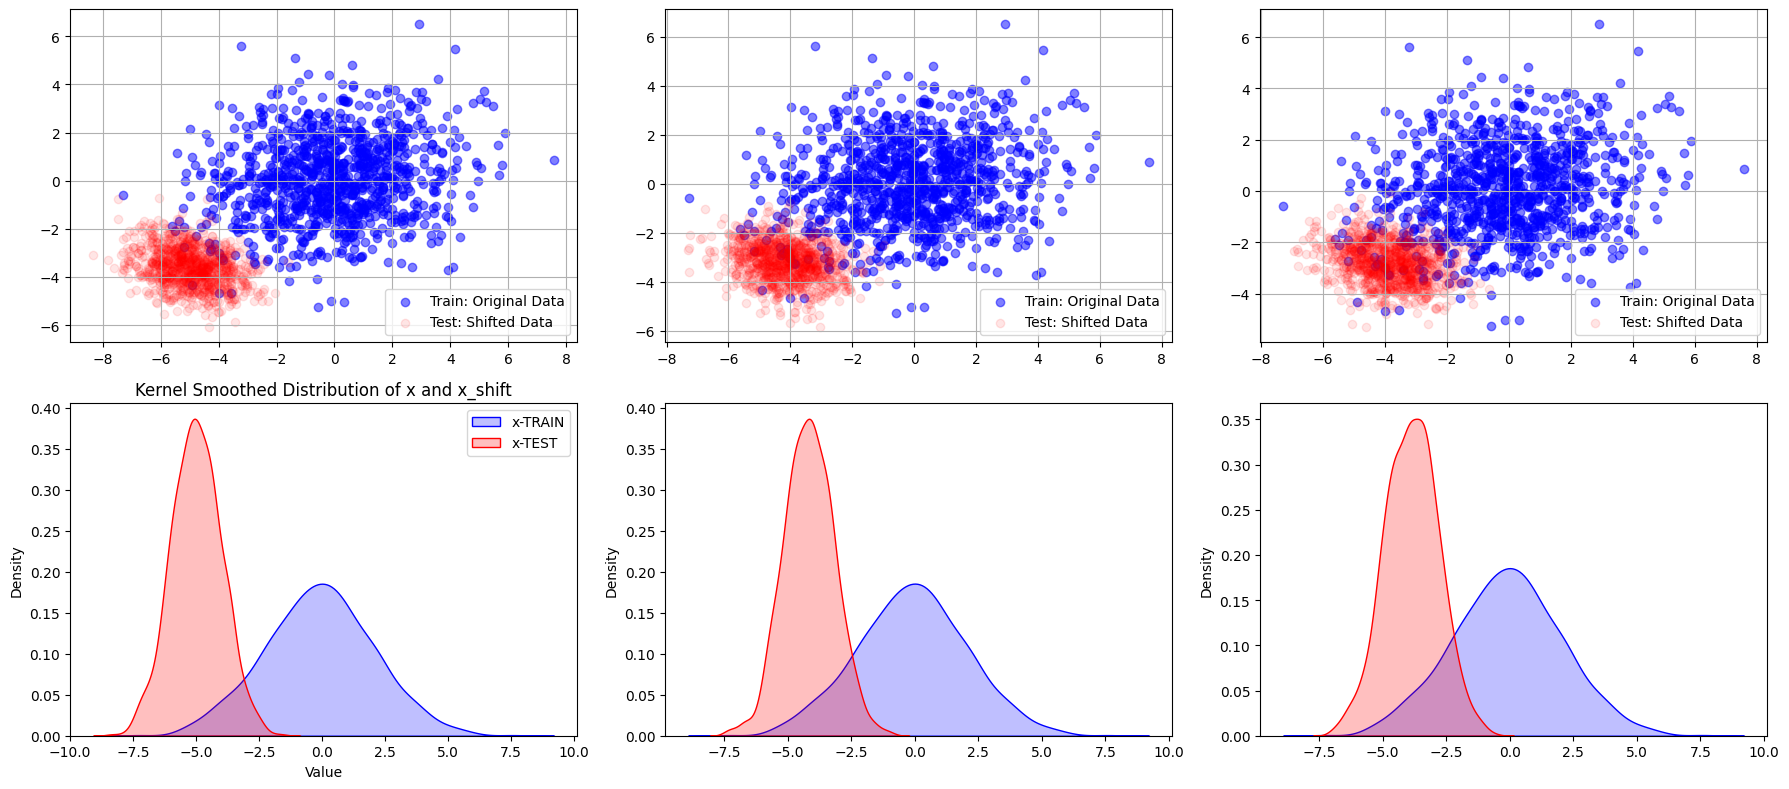

In [265]:
fig, axs = plt.subplots(2, 3, figsize=(18, 8))  # Adjust figsize as needed

# Calculate the empirical quantile
quantile_x = np.quantile(x, 0.01)
quantile_y = np.quantile(y, 0.01)
# Generazione di una nuova bivariata
mean_shift = [quantile_x, quantile_y]
cov_shift = [[1, -0.2], [-0.2, 0.6]]

x_shift, y_shift = np.random.multivariate_normal(mean_shift, cov_shift, N).T

# Plot 1
axs[0,0].scatter(x, y, color='blue', label='Train: Original Data', alpha=0.5)
axs[0,0].scatter(x_shift, y_shift, color='red', label='Test: Shifted Data', alpha=0.1)
axs[0,0].legend()
axs[0,0].grid(True)

sns.kdeplot(x, color='blue', label='x-TRAIN', fill=True,ax=axs[1, 0])
sns.kdeplot(x_shift, color='red', label='x-TEST', fill=True,ax=axs[1, 0])
axs[1, 0].set_xlabel('Value')
axs[1, 0].set_ylabel('Density')
axs[1, 0].set_title('Kernel Smoothed Distribution of x and x_shift')
axs[1, 0].legend()


# Calculate the empirical quantile
quantile_x = np.quantile(x, 0.03)
quantile_y = np.quantile(y, 0.03)
# Generazione di una nuova bivariata
mean_shift = [quantile_x, quantile_y]

x_shift, y_shift = np.random.multivariate_normal(mean_shift, cov_shift, N).T

# Plot 2
axs[0,1].scatter(x, y, color='blue', label='Train: Original Data', alpha=0.5)
axs[0,1].scatter(x_shift, y_shift, color='red', label='Test: Shifted Data', alpha=0.1)
axs[0,1].legend()
axs[0,1].grid(True)

sns.kdeplot(x, color='blue', label='x-TRAIN', fill=True,ax=axs[1, 1])
sns.kdeplot(x_shift, color='red', label='x-TEST', fill=True,ax=axs[1, 1])

# Calculate the empirical quantile
quantile_x = np.quantile(x, 0.05)
quantile_y = np.quantile(y, 0.05)
# Generazione di una nuova bivariata
mean_shift = [quantile_x, quantile_y]

x_shift, y_shift = np.random.multivariate_normal(mean_shift, cov_shift, N).T

# Plot 3
axs[0,2].scatter(x, y, color='blue', label='Train: Original Data', alpha=0.5)
axs[0,2].scatter(x_shift, y_shift, color='red', label='Test: Shifted Data', alpha=0.1)
axs[0,2].legend()
axs[0,2].grid(True)

sns.kdeplot(x, color='blue', label='x-TRAIN', fill=True,ax=axs[1, 2])
sns.kdeplot(x_shift, color='red', label='x-TEST', fill=True,ax=axs[1, 2])

plt.tight_layout()
plt.show()

# Dataset Construction

Only one training dataset, three different test sets for different shifting values.


## Function definition

In [266]:
# Conditional probability for binary classifier
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

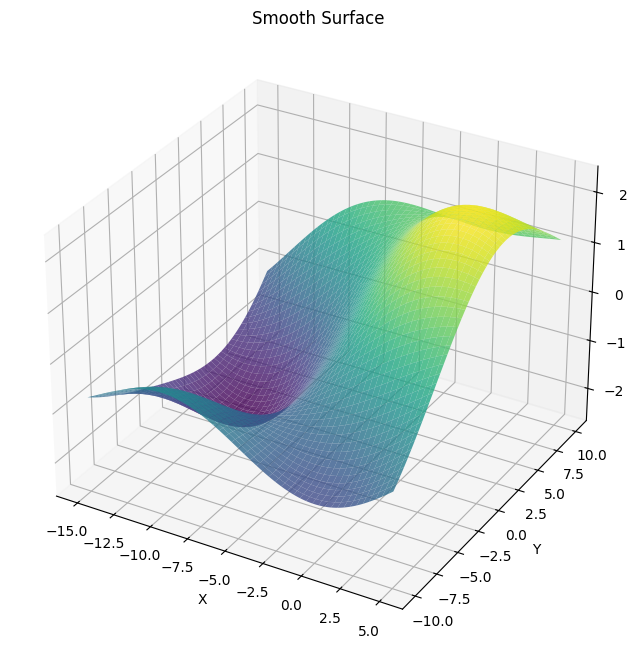

In [267]:
# Function to compute a 2D Fourier series
def fourier_surface(x, y, coefficients):
    """
    Computes a Fourier series-based function of two variables.
    :param x: Array of x values.
    :param y: Array of y values.
    :param coefficients: List of tuples (a_k, b_k, c_k) for terms in the series.
    :return: A 2D array representing the surface values.
    """
    z = np.zeros_like(x)
    for (k_x, k_y, a_k, b_k, c_k) in coefficients:
        z += a_k * np.sin(k_x * x + c_k) * np.cos(k_y * y) + b_k * np.cos(k_x * x) * np.sin(k_y * y + c_k)
    return z

# Create a grid of x and y values
x = np.linspace(-15, 5, 200)  # Adjusted the range to fit the larger period
y = np.linspace(-10, 10, 200)
X, Y = np.meshgrid(x, y)

# Define coefficients for the Fourier series with smaller k_x and k_y for larger periods
coefficients = [
    (0.1, 0.1, 1.0, 0.8, 0.0),   # k_x = 0.1, k_y = 0.1 (large period)
    (0.2, 0.1, 0.5, 0.4, np.pi / 4),  # k_x = 0.2, k_y = 0.1
    (0.1, 0.2, 0.6, 0.3, np.pi / 6),  # k_x = 0.1, k_y = 0.2
    (0.3, 0.3, 0.2, 0.7, np.pi / 3),  # k_x = 0.3, k_y = 0.3
    (0.2, 0.3, 0.3, 0.2, -np.pi / 4)  # k_x = 0.2, k_y = 0.3
]

# Compute the surface values
Z = fourier_surface(X, Y, coefficients)

# Plot the 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Smooth Surface')
plt.show()


**Remark:** the periodicity could be a problem for shift equal to the period


## Training Dataset

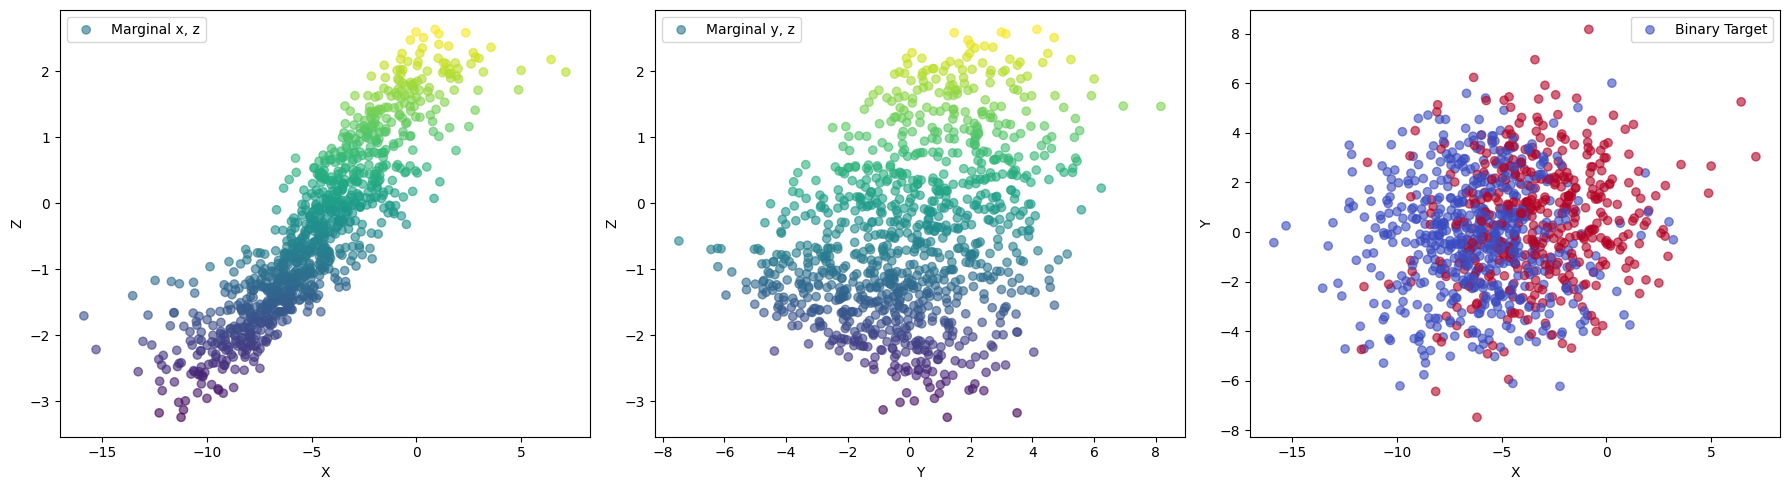

In [268]:
# build the train dataset

N = 1000

# Parametri della normale bivariata
mean = [-5, 0]  # Medie
cov = [[10, 0.8], [0.8, 6]]  # Matrice di covarianza

x, y = np.random.multivariate_normal(mean, cov, N).T

# Generating target variable
z = fourier_surface(x, y, coefficients)

# gaussian (irreducible) error
noise_std = 0.3  # Deviazione standard del rumore
epsilon = np.random.normal(0, noise_std, size=z.shape)
z_noisy = z + epsilon

# Probabilità condizionata per i nuovi dati
prob_t1 = sigmoid(z_noisy)

# Campionamento della variabile target per i nuovi dati
t = np.random.binomial(1, prob_t1)

# Creazione del DataFrame combinato
df_train = pd.DataFrame({'x': x, 'y': y, 'z': z_noisy, 't': t})

# Visualizzazione combinata
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(df_train['x'], df_train['z'], alpha=0.6, c= df_train['z'], label="Marginal x, z")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Z")
axs[0].legend()

axs[1].scatter(df_train['y'],  df_train['z'], alpha=0.6, c= df_train['z'], label="Marginal y, z")
axs[1].set_xlabel("Y")
axs[1].set_ylabel("Z")
axs[1].legend()

axs[2].scatter(df_train['x'], df_train['y'], c=df_train['t'], cmap='coolwarm', alpha=0.6, label="Binary Target")
axs[2].set_xlabel("X")
axs[2].set_ylabel("Y")
axs[2].legend()

plt.tight_layout()
plt.show()


In [269]:
t_counts = df_train['t'].value_counts()
print(t_counts)

t
0    586
1    414
Name: count, dtype: int64


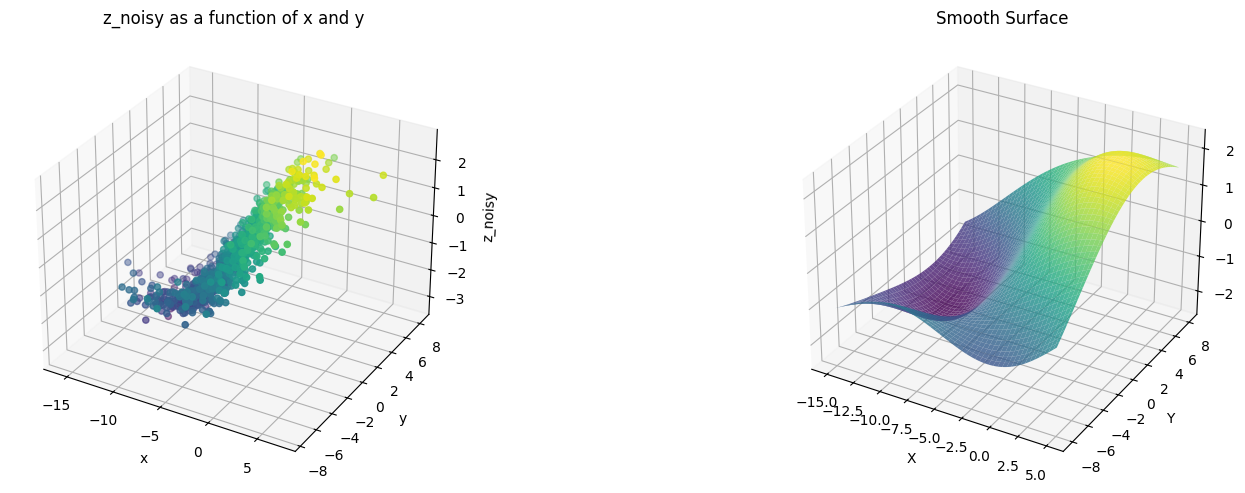

In [270]:
fig = plt.figure(figsize=(18, 5))

# Create the first subplot in 3D
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x, y, z_noisy, c=z_noisy, cmap='viridis')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z_noisy')
ax1.set_title('z_noisy as a function of x and y')

# Create the second subplot in 3D
ax2 = fig.add_subplot(122, projection='3d')
x = np.linspace(-15, 5, 200)
y = np.linspace(-8, 8, 200)
X, Y = np.meshgrid(x, y)
Z = fourier_surface(X, Y, coefficients)
ax2.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Smooth Surface')

plt.tight_layout()
plt.show()

In [271]:
# save train dataset

df_train.to_csv('train.csv', index=False)

## Testing Dataset - 01 shift

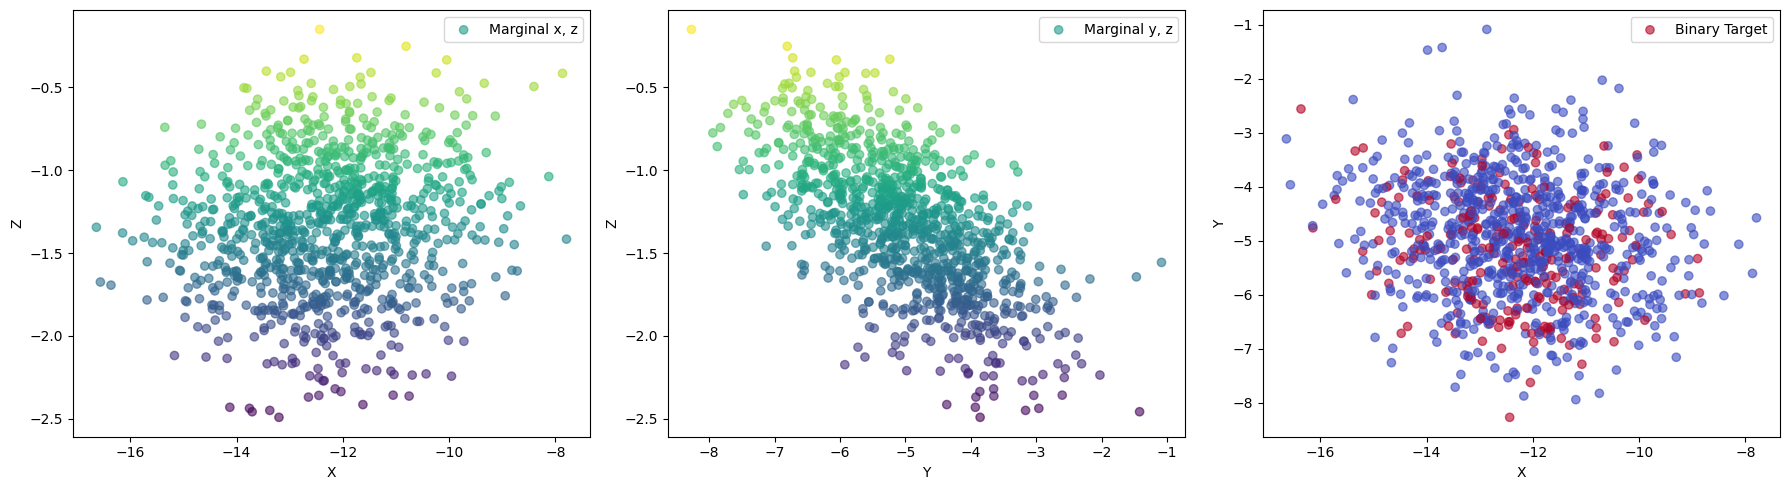

In [272]:
# Calculate the empirical quantile
probability = 0.01

quantile_x = np.quantile(df_train['x'], probability)
quantile_y = np.quantile(df_train['y'], probability)

# Generazione di una nuova bivariata
mean_shift = [quantile_x, quantile_y]
cov_shift = [[2, -0.2], [-0.2, 1.2]]

x_shift, y_shift = np.random.multivariate_normal(mean_shift, cov_shift, N).T

# Generating target variable
z_shift = fourier_surface(x_shift, y_shift, coefficients)

# gaussian (irreducible) error
noise_std = 0.3  # Deviazione standard del rumore
epsilon = np.random.normal(0, noise_std, size=z_shift.shape)
z_shift_noisy = z_shift + epsilon

# Probabilità condizionata per i nuovi dati
prob_t1 = sigmoid(z_shift_noisy)

# Campionamento della variabile target per i nuovi dati
t = np.random.binomial(1, prob_t1)

# Creazione del DataFrame combinato
df_test_01 = pd.DataFrame({'x': x_shift, 'y': y_shift, 'z': z_shift_noisy, 't': t})

# Visualizzazione combinata
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(df_test_01['x'], df_test_01['z'], alpha=0.6, c= df_test_01['z'], label="Marginal x, z")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Z")
axs[0].legend()

axs[1].scatter(df_test_01['y'],  df_test_01['z'], alpha=0.6, c= df_test_01['z'], label="Marginal y, z")
axs[1].set_xlabel("Y")
axs[1].set_ylabel("Z")
axs[1].legend()

axs[2].scatter(df_test_01['x'], df_test_01['y'], c=df_test_01['t'], cmap='coolwarm', alpha=0.6, label="Binary Target")
axs[2].set_xlabel("X")
axs[2].set_ylabel("Y")
axs[2].legend()

plt.tight_layout()
plt.show()

In [273]:
t_counts = df_test_01['t'].value_counts()
print(t_counts)

t
0    771
1    229
Name: count, dtype: int64


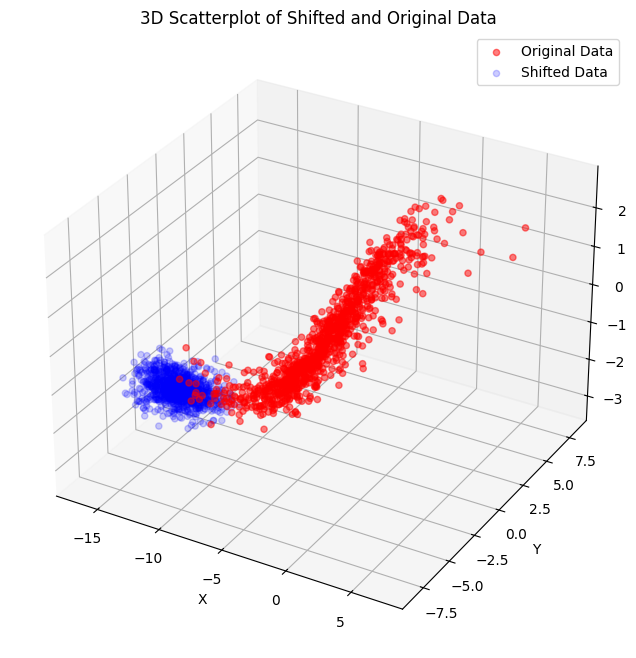

In [274]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot TRAIN
ax.scatter(df_train['x'], df_train['y'], df_train['z'], c='red', label='Original Data', alpha=0.5)
# Plot TEST
ax.scatter(df_test_01['x'], df_test_01['y'], df_test_01['z'], c='blue', label='Shifted Data', alpha=0.2)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatterplot of Shifted and Original Data')
ax.legend()

plt.show()

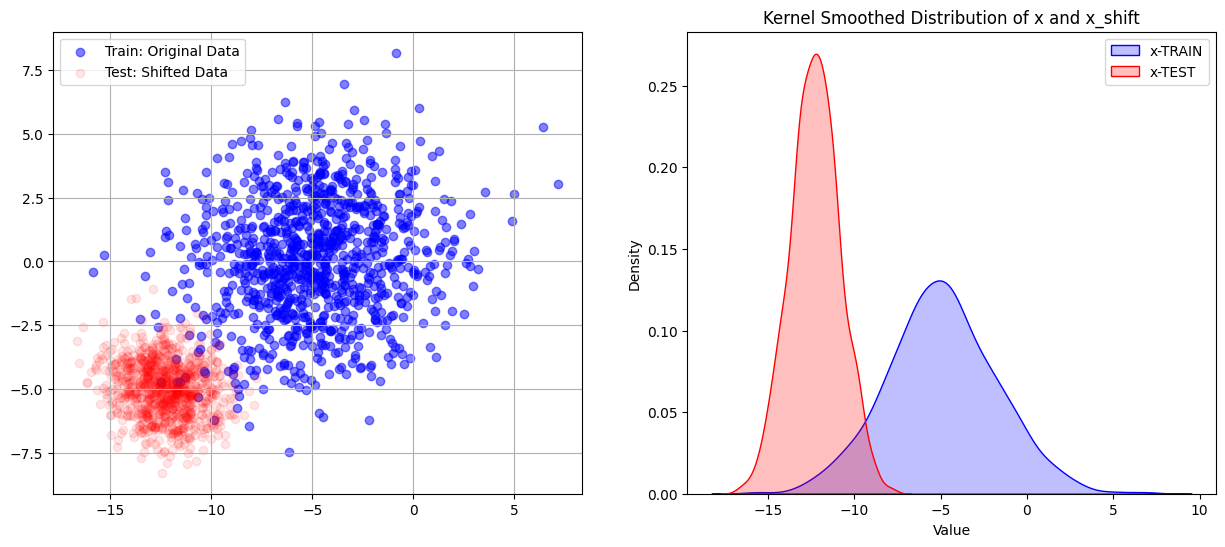

In [275]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Adjust figsize as needed

# Plot 1
axs[0].scatter(df_train['x'], df_train['y'], color='blue', label='Train: Original Data', alpha=0.5)
axs[0].scatter(df_test_01['x'], df_test_01['y'], color='red', label='Test: Shifted Data', alpha=0.1)
axs[0].legend()
axs[0].grid(True)

sns.kdeplot(df_train['x'], color='blue', label='x-TRAIN', fill=True,ax=axs[1])
sns.kdeplot(df_test_01['x'], color='red', label='x-TEST', fill=True,ax=axs[1])
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Density')
axs[1].set_title('Kernel Smoothed Distribution of x and x_shift')
axs[1].legend()

In [276]:
# save the test set
df_test_01.to_csv('test_01.csv', index=False)

## Testing Dataset - 03 shift

t
0    816
1    184
Name: count, dtype: int64


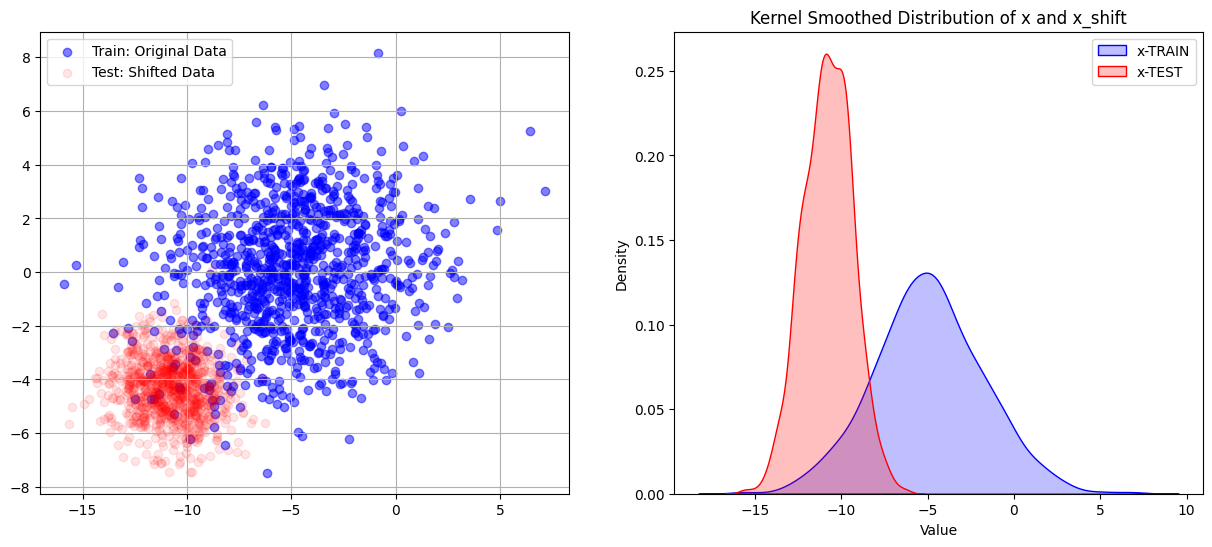

In [277]:
# Calculate the empirical quantile
probability = 0.03

quantile_x = np.quantile(df_train['x'], probability)
quantile_y = np.quantile(df_train['y'], probability)

# Generazione di una nuova bivariata
mean_shift = [quantile_x, quantile_y]
cov_shift = [[2, -0.2], [-0.2, 1.2]]

x_shift, y_shift = np.random.multivariate_normal(mean_shift, cov_shift, N).T

# Generating target variable
z_shift = fourier_surface(x_shift, y_shift, coefficients)

# gaussian (irreducible) error
noise_std = 0.3  # Deviazione standard del rumore
epsilon = np.random.normal(0, noise_std, size=z_shift.shape)
z_shift_noisy = z_shift + epsilon

# Probabilità condizionata per i nuovi dati
prob_t1 = sigmoid(z_shift_noisy)

# Campionamento della variabile target per i nuovi dati
t = np.random.binomial(1, prob_t1)

# Creazione del DataFrame combinato
df_test_03 = pd.DataFrame({'x': x_shift, 'y': y_shift, 'z': z_shift_noisy, 't': t})

t_counts = df_test_03['t'].value_counts()
print(t_counts)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Adjust figsize as needed

# Plot 1
axs[0].scatter(df_train['x'], df_train['y'], color='blue', label='Train: Original Data', alpha=0.5)
axs[0].scatter(df_test_03['x'], df_test_03['y'], color='red', label='Test: Shifted Data', alpha=0.1)
axs[0].legend()
axs[0].grid(True)

sns.kdeplot(df_train['x'], color='blue', label='x-TRAIN', fill=True,ax=axs[1])
sns.kdeplot(df_test_03['x'], color='red', label='x-TEST', fill=True,ax=axs[1])
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Density')
axs[1].set_title('Kernel Smoothed Distribution of x and x_shift')
axs[1].legend()

In [278]:
# save the test set
df_test_03.to_csv('test_03.csv', index=False)

## Testing Dataset - 05 shift

t
0    834
1    166
Name: count, dtype: int64


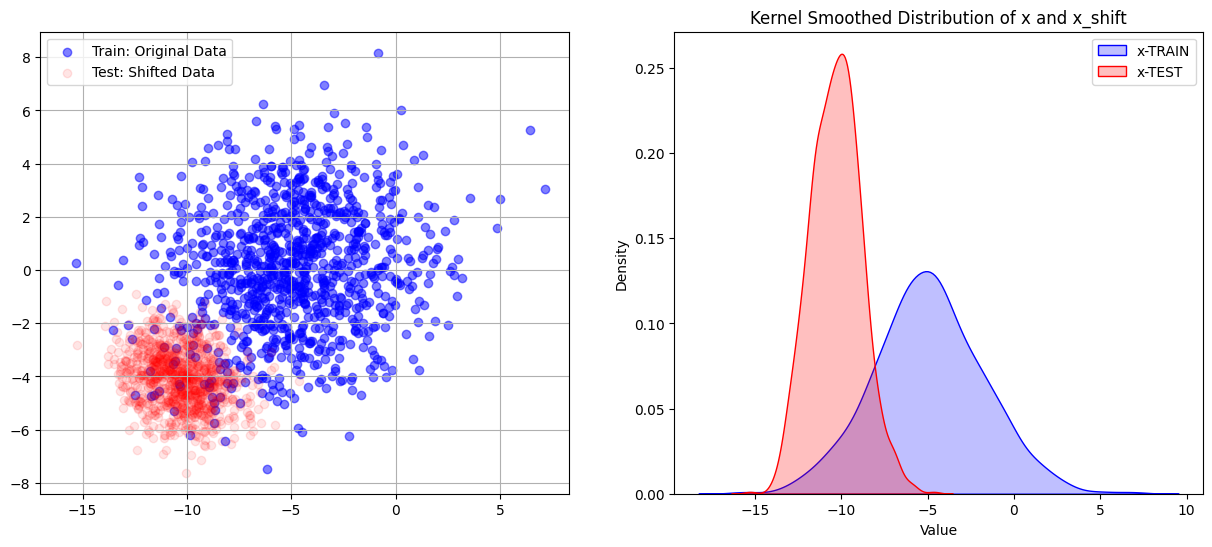

In [279]:
# Calculate the empirical quantile
probability = 0.05

quantile_x = np.quantile(df_train['x'], probability)
quantile_y = np.quantile(df_train['y'], probability)

# Generazione di una nuova bivariata
mean_shift = [quantile_x, quantile_y]
cov_shift = [[2, -0.2], [-0.2, 1.2]]

x_shift, y_shift = np.random.multivariate_normal(mean_shift, cov_shift, N).T

# Generating target variable
z_shift = fourier_surface(x_shift, y_shift, coefficients)

# gaussian (irreducible) error
noise_std = 0.3  # Deviazione standard del rumore
epsilon = np.random.normal(0, noise_std, size=z_shift.shape)
z_shift_noisy = z_shift + epsilon

# Probabilità condizionata per i nuovi dati
prob_t1 = sigmoid(z_shift_noisy)

# Campionamento della variabile target per i nuovi dati
t = np.random.binomial(1, prob_t1)

# Creazione del DataFrame combinato
df_test_05 = pd.DataFrame({'x': x_shift, 'y': y_shift, 'z': z_shift_noisy, 't': t})

t_counts = df_test_05['t'].value_counts()
print(t_counts)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Adjust figsize as needed

# Plot 1
axs[0].scatter(df_train['x'], df_train['y'], color='blue', label='Train: Original Data', alpha=0.5)
axs[0].scatter(df_test_05['x'], df_test_05['y'], color='red', label='Test: Shifted Data', alpha=0.1)
axs[0].legend()
axs[0].grid(True)

sns.kdeplot(df_train['x'], color='blue', label='x-TRAIN', fill=True,ax=axs[1])
sns.kdeplot(df_test_05['x'], color='red', label='x-TEST', fill=True,ax=axs[1])
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Density')
axs[1].set_title('Kernel Smoothed Distribution of x and x_shift')
axs[1].legend()

In [280]:
# save the test set
df_test_05.to_csv('test_05.csv', index=False)

# GAM model

In [281]:
#!pip install pygam

In [282]:
import pandas as pd
from pygam import LinearGAM, s, te
from sklearn.metrics import mean_squared_error


In [283]:
# Extract features and target
X_train = df_train[['x', 'y']].values
y_train = df_train['z'].values

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     30.4803
Link Function:                     IdentityLink Log Likelihood:                                 -4119.5441
Number of Samples:                         1000 AIC:                                             8302.0489
                                                AICc:                                            8304.1626
                                                GCV:                                                0.0906
                                                Scale:                                              0.0857
                                                Pseudo R-Squared:                                   0.9473
Feature Function                  Lam

<ipython-input-284-6038dd025d72>:7: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


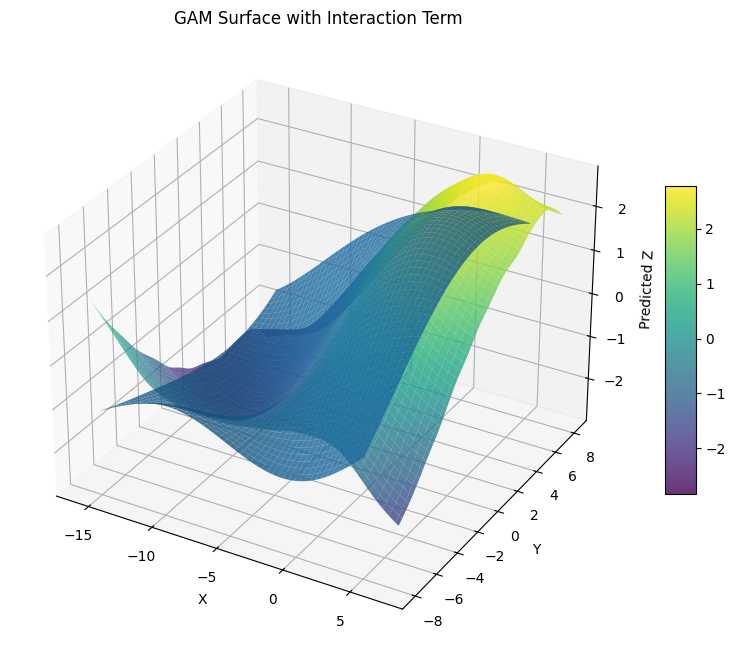

In [284]:
# Define the GAM model with interaction term
gam = LinearGAM(s(0) + s(1) + te(0, 1))  # s(0) for 'x', s(1) for 'y', te(0, 1) for interaction

# Train the GAM model
gam.fit(X_train, y_train)

gam.summary()

# Plot the surface
x_range = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100)
y_range = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Predict using the GAM model on the grid
X_grid = np.c_[x_grid.ravel(), y_grid.ravel()]
z_pred = gam.predict(X_grid).reshape(x_grid.shape)

# Surface plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x_grid, y_grid, z_pred, cmap='viridis', alpha=0.8)
fig.colorbar(surf, shrink=0.5, aspect=10)

x = np.linspace(-15, 5, 200)
y = np.linspace(-8, 8, 200)
X, Y = np.meshgrid(x, y)
Z = fourier_surface(X, Y, coefficients)
ax.plot_surface(X, Y, Z, edgecolor='none', alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Predicted Z')
ax.set_title('GAM Surface with Interaction Term')

plt.show()


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Best Lambda for each term: [[0.46415888336127775], [0.46415888336127775], [[0.46415888336127775], [0.46415888336127775]]]


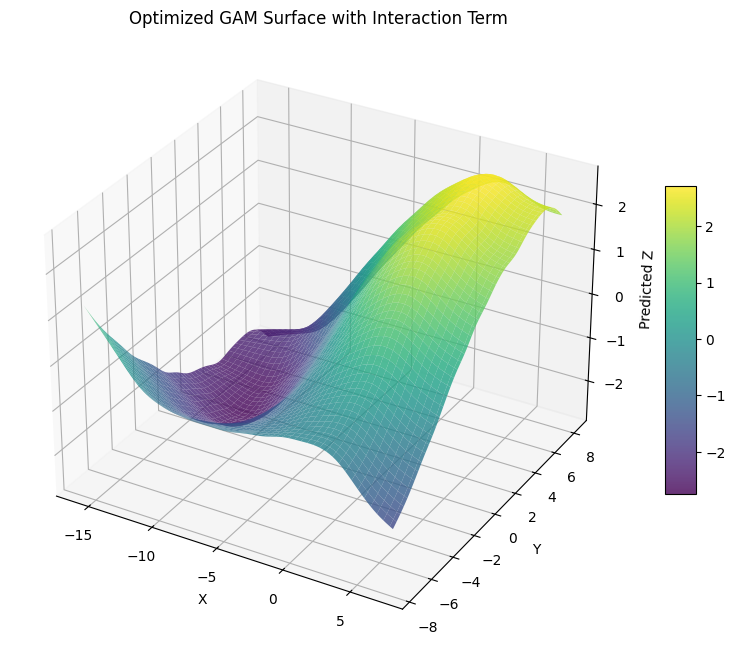

In [285]:
# Define the base GAM model with the interaction term
gam = LinearGAM(s(0) + s(1) + te(0, 1))

# Define the range of smoothing values to test for each term
lam_values = np.logspace(-3, 3, 10)  # Test smoothing parameters from 0.001 to 1000

# Perform grid search
gam.gridsearch(X_train, y_train, lam=lam_values)

# Print the optimal smoothing parameters
print("Best Lambda for each term:", gam.lam)

# Plot the surface
x_range = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100)
y_range = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Predict using the optimized GAM model on the grid
X_grid = np.c_[x_grid.ravel(), y_grid.ravel()]
z_pred = gam.predict(X_grid).reshape(x_grid.shape)

# Surface plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x_grid, y_grid, z_pred, cmap='viridis', alpha=0.8)
fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Predicted Z')
ax.set_title('Optimized GAM Surface with Interaction Term')

plt.show()


In [286]:
# Load the training and testing datasets

for df_test in [df_test_01, df_test_03, df_test_05]:
  X_test = df_test[['x', 'y']].values
  y_test = df_test['z'].values

  # Predict on the test set using the optimized GAM
  y_pred = gam.predict(X_test)

  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  print(f"Mean Squared Error on test set: {mse}")


Mean Squared Error on test set: 0.3106078051204827
Mean Squared Error on test set: 0.12446218275403473
Mean Squared Error on test set: 0.09431457696831821


In [288]:
# download all the colab files

#import glob
#from google.colab import files

# List all .csv files in the /content/ directory
#csv_files = glob.glob("/content/*.csv")

# Print the file paths
#print("CSV files found:")
#for file in csv_files:
#    print(file)

#for file in csv_files:
#    files.download(file)

CSV files found:
/content/test_05.csv
/content/test_01.csv
/content/train.csv
/content/test_03.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>